# Setup/Imports

In [4371]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, KBinsDiscretizer, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform

RSEED = 75

# Loading the data/EDA

In [4372]:
df = pd.read_csv('data/kickstarter_projects.csv', parse_dates=['Deadline', 'Launched'])
df.head()
df.columns = df.columns.str.lower()
df.head()

,id,name,category,subcategory,country,launched,deadline,goal,pledged,backers,state
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [4373]:
# Create a feature that contains the length of the name of the campaign and drop the name
df['name_length'] = df['name'].str.len()
df = df.drop(['name', 'id'], axis=1)
df.head()

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,59
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,30
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,19
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,28
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,10


In [4374]:
# Create a feature with timespan between launch and deadline
df['campaign_duration'] = (df['deadline']-df['launched']).dt.days
df.head()


,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,59,39
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,30,87
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,19,8
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,28,79
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,10,28


In [4375]:
# Create feature with the month of the launch and deadline
df['launched_month'] = df['launched'].dt.month
df['deadline_month'] = df['deadline'].dt.month
df.sample(5)

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month
114238,Music,Rock,United States,2013-10-10 18:24:10,2013-11-09,3000,0,0,Failed,60,29,10,11
278394,Food,Drinks,United States,2016-03-12 17:22:50,2016-04-26,15000,345,16,Canceled,52,44,3,4
354982,Music,Rock,United States,2017-08-05 17:15:40,2017-08-25,1500,5,1,Failed,55,19,8,8
25116,Music,Music,United States,2011-07-14 02:46:38,2011-08-13,10000,10127,114,Successful,33,29,7,8
12877,Dance,Dance,United States,2011-01-22 02:34:57,2011-02-26,3000,4276,50,Successful,27,34,1,2


In [4376]:
# Create a feature with the quarter of the launch and dealine
df['launched_quarter'] = (df['launched_month'] - 1) // 3 + 1
df['deadline_quarter'] = (df['deadline_month'] - 1) // 3 + 1
df.sample(5)

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
151790,Crafts,Crafts,United States,2014-07-08 23:52:24,2014-08-07,100,101,2,Successful,35,29,7,8,3,3
145319,Theater,Musical,United States,2014-06-03 05:54:26,2014-06-23,2000,2760,36,Successful,42,19,6,6,2,2
241572,Food,Cookbooks,United States,2015-08-12 14:00:24,2015-09-11,16600,5292,113,Failed,14,29,8,9,3,3
352315,Theater,Theater,United States,2017-07-18 05:12:22,2017-07-24,2000,0,0,Canceled,15,5,7,7,3,3
72016,Film & Video,Documentary,United States,2012-10-16 06:34:03,2012-11-15,20000,5110,71,Failed,7,29,10,11,4,4


In [4377]:
df['state'].value_counts()
#df = df.drop[df['state'] == 'Live'],axis=0)

df.drop(df[df['state'] == 'Live'].index, inplace=True)

In [4378]:
# Check what kind of states we have 
df['state'].value_counts()


state
Failed        197611
Successful    133851
Canceled       38751
Suspended       1842
Name: count, dtype: int64

In [4379]:
# Include the state 'canceled' and 'suspendend' in the 'failed' state and transform 'failed' to 0 and 'successful' to 1

df['state'] = df['state'].replace(['Failed', 'Canceled', 'Suspended'], 0) # Failed = 0
df['state'] = df['state'].replace('Successful', 1) #Successfull = 1

df.head()

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,0,59,39,4,5,2,2
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,0,30,87,4,7,2,3
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,1,19,8,4,5,2,2
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,1,28,79,4,7,2,3
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,0,10,28,4,5,2,2


<Axes: xlabel='state', ylabel='count'>

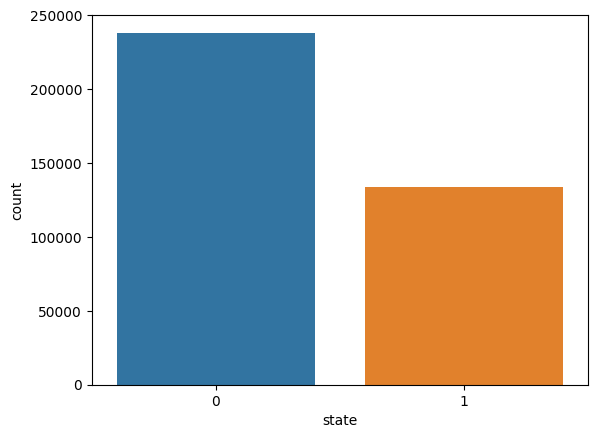

In [4380]:
sns.countplot(data=df, x='state')

In [4381]:
df.describe()

,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
count,372055,372055,3.720550e+05,3.720550e+05,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000
mean,2014-09-17 16:56:47.029393152,2014-10-21 07:34:21.440378624,4.573831e+04,9.145513e+03,106.980393,0.359761,34.873191,33.175141,6.428238,6.766121,2.485866,2.580428
min,2009-04-21 21:02:48,2009-05-03 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2013-04-24 20:46:51,2013-05-27 00:00:00,2.000000e+03,3.100000e+01,2.000000,0.000000,21.000000,29.000000,4.000000,4.000000,2.000000,2.000000
50%,2014-11-24 21:12:56,2014-12-30 00:00:00,5.500000e+03,6.280000e+02,12.000000,0.000000,34.000000,29.000000,6.000000,7.000000,2.000000,3.000000
75%,2016-03-16 05:30:40.500000,2016-04-19 00:00:00,1.600000e+04,4.066000e+03,57.000000,1.000000,49.000000,36.000000,9.000000,10.000000,3.000000,4.000000
max,2018-01-02 03:05:10,2018-02-24 00:00:00,1.663614e+08,2.033899e+07,219382.000000,1.000000,96.000000,91.000000,12.000000,12.000000,4.000000,4.000000
std,NaN,NaN,1.151699e+06,9.162231e+04,914.532666,0.479931,15.942159,12.793434,3.307690,3.318672,1.094263,1.085238


In [4382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372055 entries, 0 to 374823
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           372055 non-null  object        
 1   subcategory        372055 non-null  object        
 2   country            372055 non-null  object        
 3   launched           372055 non-null  datetime64[ns]
 4   deadline           372055 non-null  datetime64[ns]
 5   goal               372055 non-null  int64         
 6   pledged            372055 non-null  int64         
 7   backers            372055 non-null  int64         
 8   state              372055 non-null  int64         
 9   name_length        372055 non-null  int64         
 10  campaign_duration  372055 non-null  int64         
 11  launched_month     372055 non-null  int32         
 12  deadline_month     372055 non-null  int32         
 13  launched_quarter   372055 non-null  int32        

In [4383]:
list_of_countries = pd.DataFrame(df['country'].value_counts(normalize=True)*100)
list_of_countries

,proportion
country,
United States,78.181452
United Kingdom,8.975017
Canada,3.930602
Australia,2.088132
Germany,1.100912
France,0.775961
Netherlands,0.761447
Italy,0.753114
Spain,0.597761


In [4384]:

other_countries = list_of_countries[list_of_countries['proportion'] < 1]

In [4385]:
other_countries

,proportion
country,
France,0.775961
Netherlands,0.761447
Italy,0.753114
Spain,0.597761
Sweden,0.466866
Mexico,0.442139
New Zealand,0.385964
Denmark,0.294849
Ireland,0.215022


In [4386]:
df['country'].replace(other_countries.index, 'other', inplace=True)
df['country'].value_counts()

country
United States     290878
United Kingdom     33392
other              21296
Canada             14624
Australia           7769
Germany             4096
Name: count, dtype: int64

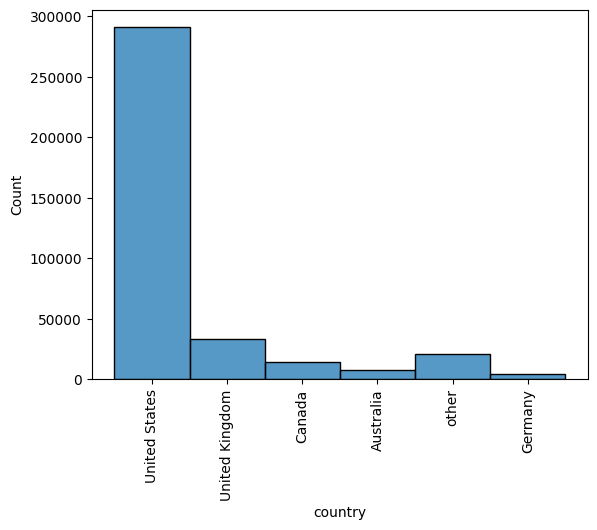

In [4387]:
ax = sns.histplot(data=df['country'])
ax.tick_params(axis='x', rotation=90)

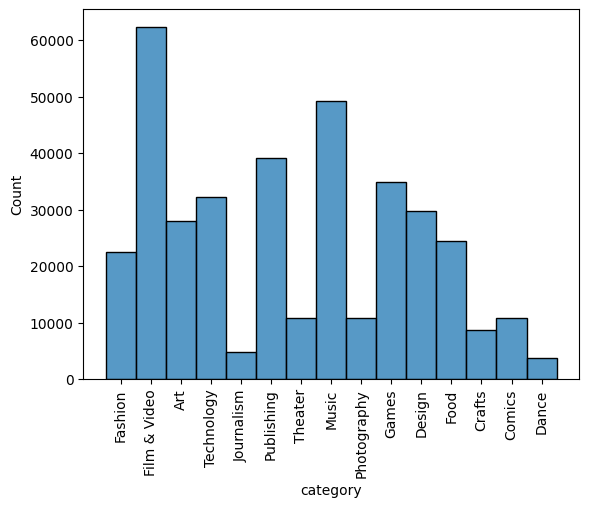

In [4388]:
ax = sns.histplot(data=df['category'])
ax.tick_params(axis='x', rotation=90)

In [4389]:
df['category'].value_counts(normalize=True)*100

category
Film & Video    16.761500
Music           13.236753
Publishing      10.503555
Games            9.390547
Technology       8.650603
Design           7.998817
Art              7.514212
Food             6.562471
Fashion          6.064157
Theater          2.921611
Comics           2.887476
Photography      2.883982
Crafts           2.347234
Journalism       1.269436
Dance            1.007647
Name: proportion, dtype: float64

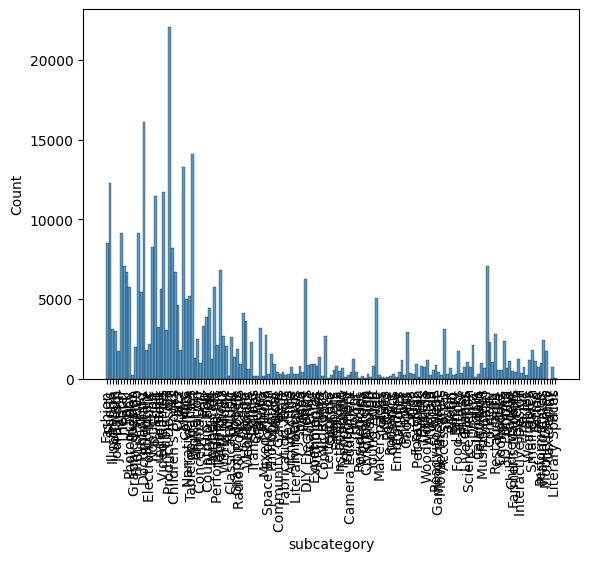

In [4390]:
ax = sns.histplot(data=df['subcategory'])
ax.tick_params(axis='x', rotation=90)

In [4391]:
df['subcategory'].value_counts(normalize=True)*100
#Too many subcategories, ignore for first model


subcategory
Product Design     5.932725
Documentary        4.322210
Tabletop Games     3.781699
Music              3.563720
Shorts             3.308919
                     ...   
Residencies        0.018546
Letterpress        0.012901
Chiptune           0.009407
Literary Spaces    0.006182
Taxidermy          0.003494
Name: proportion, Length: 159, dtype: float64

<Axes: >

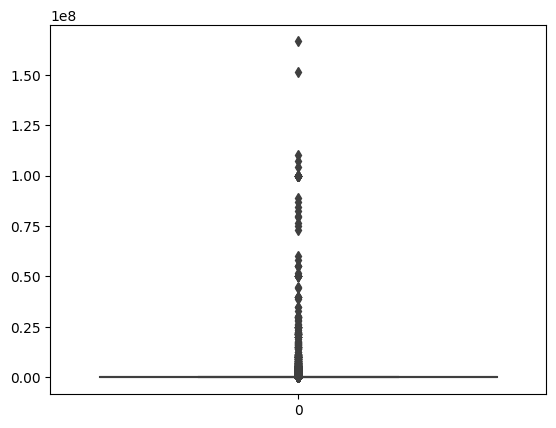

In [4392]:
sns.boxplot(data=df['goal'])



In [4393]:
zero_goal = df[df['goal'] < 10]
zero_goal

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
595,Music,Music,United States,2009-09-15 07:12:42,2009-11-16,2,0,0,0,20,61,9,11,3,4
738,Art,Conceptual Art,United States,2009-10-06 11:35:47,2009-10-21,1,144,5,1,54,14,10,10,4,4
1085,Art,Conceptual Art,United States,2009-11-25 07:54:49,2009-12-04,0,100,6,1,39,8,11,12,4,4
1256,Art,Art,United States,2009-12-17 23:57:50,2009-12-26,1,336,8,1,41,8,12,12,4,4
1409,Art,Performance Art,United States,2010-01-09 23:46:08,2010-04-01,1,0,0,0,10,81,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370924,Design,Product Design,United States,2017-11-22 19:52:28,2017-12-09,1,11,1,1,28,16,11,12,4,4
371660,Film & Video,Film & Video,United States,2017-11-29 00:01:03,2017-12-29,1,1,1,0,39,29,11,12,4,4
371829,Music,Music,Canada,2017-11-30 01:27:27,2017-12-30,2,2,1,1,11,29,11,12,4,4
373911,Art,Art,United States,2017-12-18 21:38:26,2017-12-25,1,74,17,0,57,6,12,12,4,4


In [4394]:
bins = [-1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 167000000]
label = [1,2,3,4,5,6,7, 8]


df['binned_goal'] = pd.cut(df['goal'], bins = bins, labels=label)

df.head()



,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter,binned_goal
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,0,59,39,4,5,2,2,3
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,0,30,87,4,7,2,3,5
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,1,19,8,4,5,2,2,2
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,1,28,79,4,7,2,3,2
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,0,10,28,4,5,2,2,4


In [4395]:
df['goal'].max()

166361391

<Axes: xlabel='binned_goal', ylabel='Count'>

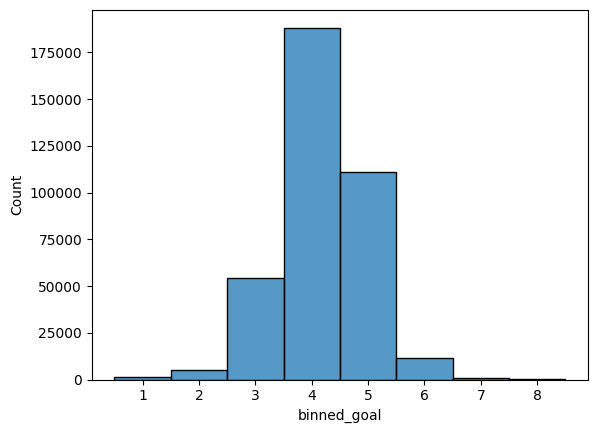

In [4396]:
sns.histplot(data=df, x = 'binned_goal')


In [4397]:
df[df['binned_goal'].isnull()]

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter,binned_goal


In [4398]:
df.isna().sum()

category             0
subcategory          0
country              0
launched             0
deadline             0
goal                 0
pledged              0
backers              0
state                0
name_length          0
campaign_duration    0
launched_month       0
deadline_month       0
launched_quarter     0
deadline_quarter     0
binned_goal          0
dtype: int64

In [4399]:
df['backers'].describe()

count    372055.000000
mean        106.980393
std         914.532666
min           0.000000
25%           2.000000
50%          12.000000
75%          57.000000
max      219382.000000
Name: backers, dtype: float64

<Axes: xlabel='backers'>

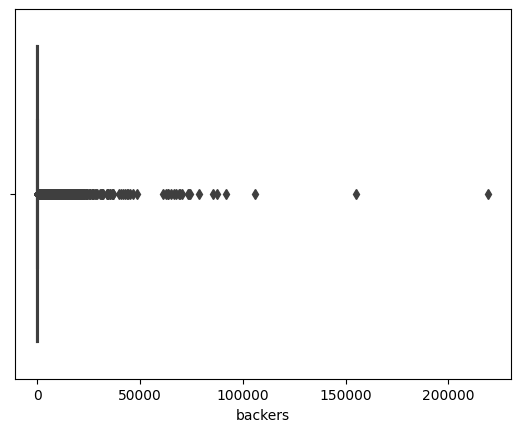

In [4400]:
sns.boxplot(data=df, x='backers')

In [4401]:
df['backers'].value_counts()

backers
0       51256
1       34530
2       22996
3       15929
4       11954
        ...  
3463        1
7794        1
1657        1
1819        1
2296        1
Name: count, Length: 3952, dtype: int64

In [4402]:
df['backers'].max()

219382

In [4403]:
bins = [-1, 1000,10_000, 100_000, 300_000]
label = [1,2,3, 4]

df['binned_backers'] = pd.cut(df['backers'], bins = bins, labels=label)

df.head(10)

#sns.countplot
df.isna().sum()

category             0
subcategory          0
country              0
launched             0
deadline             0
goal                 0
pledged              0
backers              0
state                0
name_length          0
campaign_duration    0
launched_month       0
deadline_month       0
launched_quarter     0
deadline_quarter     0
binned_goal          0
binned_backers       0
dtype: int64

<Axes: xlabel='binned_backers', ylabel='Count'>

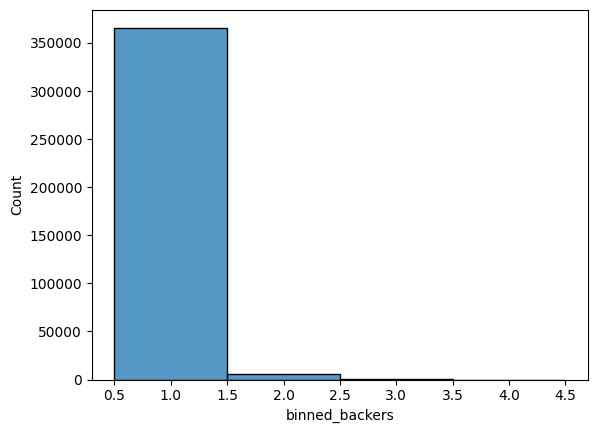

In [4404]:
sns.histplot(data=df, x = 'binned_backers')


In [4405]:
bins = [-1,1_000,10_000,100_000,1_000_000, 21_000_000]
label = [1,2,3,4,5]

df['binned_pledged'] = pd.cut(df['pledged'], bins = bins, labels=label)

In [4406]:
#sns.pairplot(data=df.sample(frac=0.001), hue='state')

In [4407]:
df.columns

Index(['category', 'subcategory', 'country', 'launched', 'deadline', 'goal',
       'pledged', 'backers', 'state', 'name_length', 'campaign_duration',
       'launched_month', 'deadline_month', 'launched_quarter',
       'deadline_quarter', 'binned_goal', 'binned_backers', 'binned_pledged'],
      dtype='object')

In [4408]:

temp = df.drop(columns=['category', 'country', 'launched', 'deadline', 'subcategory'])
corr = temp.sample(frac=0.01).corr()
plt.figure(figsize=(20,10))
#sns.heatmap(corr, annot=True)

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Axes: xlabel='name_length', ylabel='Count'>

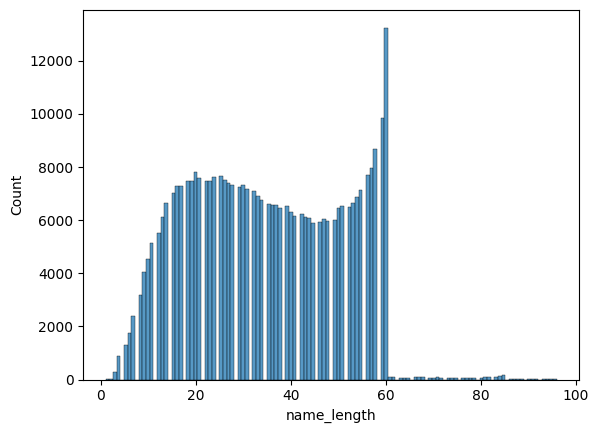

In [4409]:
sns.histplot(x=df.name_length)

<Axes: xlabel='binned_pledged', ylabel='Count'>

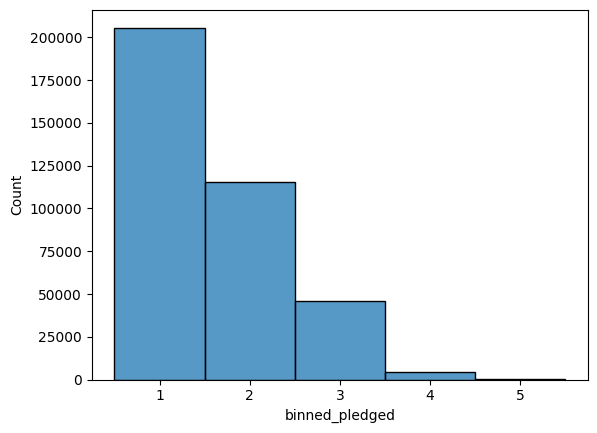

In [4410]:
sns.histplot(x=df.binned_pledged)

In [4411]:
df['category'].unique().shape

(15,)

In [4412]:
#create a new df to not change the originally prepared
df_category_grouped = df.copy()
df_category_grouped['category'].unique()

array(['Fashion', 'Film & Video', 'Art', 'Technology', 'Journalism',
       'Publishing', 'Theater', 'Music', 'Photography', 'Games', 'Design',
       'Food', 'Crafts', 'Comics', 'Dance'], dtype=object)

In [4413]:
df_category_grouped['category'] = df_category_grouped['category'].replace(['Art', 'Design', 'Theater', 'Dance'], 'art') # group into art column
df_category_grouped['category'] = df_category_grouped['category'].replace(['Technology'], 'technology') # group into technology column
df_category_grouped['category'] = df_category_grouped['category'].replace(['Journalism', 'Publishing', 'Film & Video', 'Photography', 'Music'], 'multimedia') # group into published_media column
df_category_grouped['category'] = df_category_grouped['category'].replace(['Games', 'Food', 'Comics', 'Fashion', 'Crafts'], 'consumer_goods') # group into art column

In [4414]:
df_category_grouped['category'].unique()

array(['consumer_goods', 'multimedia', 'art', 'technology'], dtype=object)

<Axes: xlabel='name_length', ylabel='state'>

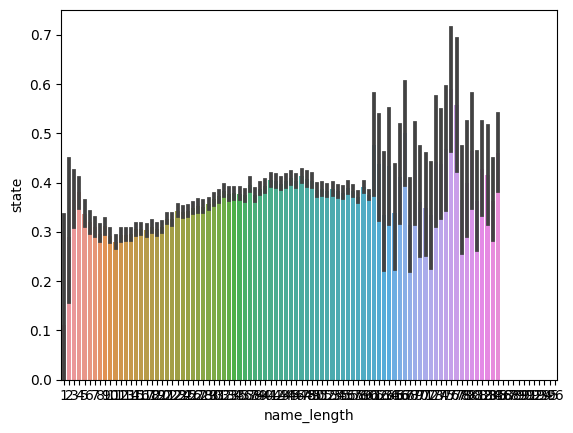

In [4415]:
sns.barplot(data=df_category_grouped, x='name_length', y='state')

# Feature Engineering/Preprocessing

## Preprocessing

In [4416]:
df_category_grouped.columns

Index(['category', 'subcategory', 'country', 'launched', 'deadline', 'goal',
       'pledged', 'backers', 'state', 'name_length', 'campaign_duration',
       'launched_month', 'deadline_month', 'launched_quarter',
       'deadline_quarter', 'binned_goal', 'binned_backers', 'binned_pledged'],
      dtype='object')

In [4426]:
features = ['goal', 'category', 'name_length'] 
target = 'state'
X = df_category_grouped[features]
y = df_category_grouped[target]

In [4427]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=RSEED)

In [4428]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (297644, 3)
X_test shape:  (74411, 3)
y_train shape:  (297644,)
y_test shape:  (74411,)


In [4429]:
num_cols = ['goal', 'name_length'] 
cat_cols = ['category']

In [4430]:
num_pipeline = Pipeline([
    #('scaling', RobustScaler())
    ('binning', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile', random_state=RSEED, subsample=None))
    #('powertransformer', PowerTransformer(n_bins=5, encode='ordinal', strategy='quantile', random_state=RSEED, subsample=None))
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first'))
])

In [4431]:
fe_transformer = ColumnTransformer([
    ('num_transform', num_pipeline, num_cols),
    ('cat_transform', cat_pipeline, cat_cols)
], remainder='passthrough')

In [4440]:
X_temp = X_train.sample(frac=0.5, random_state=RSEED)
y_temp = y_train.sample(frac=0.5, random_state=RSEED)

In [4232]:
unique_values, counts = np.unique(y_temp, return_counts=True)
unique_values, counts

(array([0, 1]), array([95330, 53492]))

## Baseline Model

### Hypothesis: if goal < Backers * average pledge Success else Fail

In [3128]:
# def baseline(X_data):
#     #average pledge = each pledge / their corresponding number of backers
#     #overall average = sum of all pledges / sum of all backers
#     avg_pledge_per_backer = X_data['pledged'] / X_data['backers']

#     #the goal 
#     return X_data['goal'] <= X_data['backers'] * avg_pledge_per_backer.mean()

In [3622]:
#predicts that if the goal is within the first quantile it will be successful, otherwise fail.
def baseline(X_data):
    first_quartile = X_data['goal'].quantile(0.25)
    return X_data['goal'] <= X_data['goal'].quantile(0.25)

In [3623]:
y_train_pred_baseline = baseline(X_train)
score = roc_auc_score(y_temp, y_pred_proba)
score

0.6683888529024662

In [3624]:
print('Accuracy: ', accuracy_score(y_train, y_train_pred_baseline).round(2))
print('Recall: ', recall_score(y_train, y_train_pred_baseline).round(2))
print('Precision: ', precision_score(y_train, y_train_pred_baseline).round(2))
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred_baseline).round(2))

Accuracy:  0.63
Recall:  0.35
Precision:  0.48
ROC-AUC:  0.57


In [3625]:
confusion_matrix(y_train, y_train_pred_baseline)

array([[150141,  40422],
       [ 69439,  37642]])

## First simple ML model (Logistic Regression)

In [4158]:
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', LogisticRegression(max_iter=1000))
])

In [4159]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=3,
                                                                                    random_state=75,
                                                                                    subsample=None))]),
                                                  ['goal', 'name_length']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [4160]:
y_train_pred = model_pipeline.predict(X_train)

In [4161]:
feature_names = fe_transformer.get_feature_names_out()
feature_names

array(['num_transform__goal', 'num_transform__name_length',
       'cat_transform__category_consumer_goods',
       'cat_transform__category_multimedia',
       'cat_transform__category_technology'], dtype=object)

In [4162]:
processed_feature_names = model_pipeline.named_steps['preprocessing'].get_feature_names_out()
processed_feature_names

array(['num_transform__goal', 'num_transform__name_length',
       'cat_transform__category_consumer_goods',
       'cat_transform__category_multimedia',
       'cat_transform__category_technology'], dtype=object)

In [4163]:
print('Accuracy: ', accuracy_score(y_train, y_train_pred).round(2))
print('Recall: ', recall_score(y_train, y_train_pred).round(2))
print('Precision: ', precision_score(y_train, y_train_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred).round(2))


Accuracy:  0.65
Recall:  0.21
Precision:  0.52
ROC-AUC:  0.55


In [4164]:
confusion_matrix(y_train, y_train_pred)

array([[169715,  20848],
       [ 84506,  22575]])

In [4165]:
cross_val_score(model_pipeline, X_train, y_train, cv=5, n_jobs=-1)

array([0.64607166, 0.64511415, 0.64714677, 0.64672681, 0.64514178])

## Bagging Models

### Model: RF

In [3908]:
# bootstrap=True, max_depth=10, min_samples_leaf=15, min_samples_split=10, max_samples=0.6, n_estimators=100, class_weight={0:1, 1:2}
# (max_depth=30, class_weight='balanced', min_samples_leaf=20, n_estimators=200, max_samples=0.6, min_samples_split=10)
rf = RandomForestClassifier(max_depth=30, class_weight='balanced', min_samples_leaf=20, n_estimators=200, max_samples=0.6, min_samples_split=10)

In [3904]:
#random forest uses bagging internally
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', rf)
])

In [3829]:
#grid search for rf
#total fits = len(param)n * cv = 2 max depth * 2 min sample leaf * 1 max sample * 1 class weight * 5 = 20

param_rf = {
            #'model__criterion':['gini','entropy'],
            'model__max_depth': [25,30],
            'model__n_estimators': [25,50],
            #'model__max_features': ['sqrt'],
            'model__min_samples_leaf': [15,20],
            #'model__min_samples_split': [10,15],
            'model__max_samples': [0.5],
            'model__class_weight': ['balanced', {0:1, 1:2}]
            }

grid_rf = GridSearchCV(
    estimator=model_pipeline, 
    param_grid=param_rf, 
    cv=5, 
    scoring=['accuracy','roc_auc'], 
    refit='roc_auc',
    verbose=5, 
    return_train_score=True,
    n_jobs=-1
)

grid_rf.fit(X_temp, y_temp)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 3/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=0.615, test=0.605) roc_auc: (train=0.666, test=0.651) total time=   1.1s
[CV 2/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=0.615, test=0.610) roc_auc: (train=0.664, test=0.658) total time=   1.1s
[CV 1/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=0.613, test=0.613) roc_auc: (train=0.664, test=0.660) total time=   1.1s
[CV 4/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=0.611, test=0.607) roc_auc: (train=0.663, test=0.661) total time=   1.1s
[CV 5/5] END model_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_transform',
                                                                         Pipeline(steps=[('binning',
                                                                                          KBinsDiscretizer(encode='ordinal',
                                                                                                           n_bins=3,
                                                                                                           random_state=75,
                                                                                                           subsample=None))]),
                                                                         ['goal',
                                                                          'name_length',
                                                                          'campaign_duration']),
                                                                        ('cat_transform',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first')...
                                                               max_depth=30,
                                                               max_samples=0.7,
                                                               min_samples_leaf=3,
                                                               min_samples_split=5,
                                                               n_estimators=300))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced', {0: 1, 1: 2}],
                         'model__max_depth': [25, 30],
                         'model__max_samples': [0.5],
                         'model__min_samples_leaf': [15, 20],
                         'model__n_estimators': [25, 50]},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'roc_auc'], verbose=5)

In [3830]:
print(f"Best score_ROC:\n {(grid_rf.best_score_).round(2)}")
print(f"Best score:\n {(grid_rf.best_params_)}")

Best score_ROC:
 0.66
Best score:
 {'model__class_weight': {0: 1, 1: 2}, 'model__max_depth': 30, 'model__max_samples': 0.5, 'model__min_samples_leaf': 20, 'model__n_estimators': 50}


In [3905]:
model_pipeline.fit(X_temp, y_temp)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=3,
                                                                                    random_state=75,
                                                                                    subsample=None))]),
                                                  ['goal', 'name_length']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category',
                                                   'launched_quarter'])])),
                ('model', RandomForestClassifier())])

In [3906]:
y_temp_pred = model_pipeline.predict(X_temp)
y_pred_proba = model_pipeline.predict_proba(X_temp)[:, 1] #prob of positive class
score = roc_auc_score(y_temp, y_pred_proba)
score

0.6479602881548029

In [3907]:
print('Accuracy: ', accuracy_score(y_temp, y_temp_pred).round(2))
print('Recall: ', recall_score(y_temp, y_temp_pred).round(2))
print('Precision: ', precision_score(y_temp, y_temp_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_temp, y_temp_pred).round(2))
print(f"Confusion Matrix \n {confusion_matrix(y_temp, y_temp_pred)}")

print(f"Cross Val Score Accuracy: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='accuracy').round(2)}")
print(f"Cross Val Score Recall: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='recall').round(2)}")
print(f"Cross Val Score ROC: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='roc_auc').round(2)}")


Accuracy:  0.65
Recall:  0.22
Precision:  0.53
ROC-AUC:  0.56
Confusion Matrix 
 [[84993 10337]
 [41807 11685]]
Cross Val Score Accuracy: 
 [0.65 0.65 0.64 0.65 0.65]
Cross Val Score Recall: 
 [0.23 0.24 0.24 0.2  0.2 ]
Cross Val Score ROC: 
 [0.65 0.65 0.64 0.65 0.65]


In [3644]:
model_pipeline.named_steps['model'].feature_importances_

array([0.52503001, 0.11042713, 0.16605138, 0.05703928, 0.01891225,
       0.12253994])

In [3645]:
feature_names

array(['num_transform__goal', 'num_transform__name_length',
       'num_transform__campaign_duration',
       'cat_transform__category_consumer_goods',
       'cat_transform__category_multimedia',
       'cat_transform__category_technology'], dtype=object)

### Bagging with Decision Tree

In [3972]:
# #Trial 2
param_dt = {
    'model__estimator__max_depth': [15,20],
    'model__estimator__min_samples_split': [5,10],
    'model__estimator__min_samples_leaf': [3],
    'model__estimator__class_weight': ['balanced'],
    #'model__estimator__criterion': ['gini', 'entropy'],
    'model__n_estimators': [25,50],
    #'model__max_samples': [0.6],
    'model__bootstrap': [True]
}


In [4051]:
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1))
])

In [3974]:
grid_dt = GridSearchCV(
    model_pipeline,
    param_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)

grid_dt.fit(X_temp, y_temp)
print(f"Best score_ROC:\n {(grid_dt.best_score_).round(2)}")
print(f"Best score:\n {(grid_dt.best_params_)}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=5, model__n_estimators=25;, score=0.631 total time=   3.0s
[CV 4/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=5, model__n_estimators=25;, score=0.636 total time=   3.1s
[CV 5/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=5, model__n_estimators=25;, score=0.637 total time=   3.1s
[CV 1/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=5, model__n_estimators=25;, sco

/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=10, model__n_estimators=50;, score=0.631 total time=   4.7s
[CV 1/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=10, model__n_estimators=50;, score=0.632 total time=   5.0s
[CV 4/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=10, model__n_estimators=50;, score=0.636 total time=   4.7s
[CV 3/5] END model__bootstrap=True, model__estimator__class_weight=balanced, model__estimator__max_depth=15, model__estimator__min_samples_leaf=3, model__estimator__min_samples_split=10, model__n_estimators=50;, score=0.627 total time=   4.8s
[CV 5/5] END model__bootstra

In [3975]:
best_model = grid_dt.best_estimator_

feat_importance = best_model.named_steps['model'].estimators_[0].feature_importances_
feat_importance
#len(feat_importance), len(cat_cols), len(num_cols)

array([0.44094175, 0.04399781, 0.02045177, 0.07303911, 0.03540943,
       0.03128277, 0.03128216, 0.32359521])

In [2584]:
# #Trial 4
param_dt_rand = {
    'model__estimator__max_depth': randint(10,20),
    'model__estimator__min_samples_split': randint(20,50),
    'model__estimator__min_samples_leaf': randint(10,20),
    'model__estimator__class_weight': ['balanced'],
    'model__estimator__criterion': ['gini', 'entropy'],
    'model__n_estimators': [200],
    'model__max_samples': uniform(0.5,0.7),
    'model__bootstrap': [True]
}

In [2585]:
#random search
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1))
])
grid_dt = RandomizedSearchCV(
    model_pipeline,
    param_dt_rand,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_dt.fit(X_temp, y_temp)
print(f"Best RAND score_ROC:\n {(grid_dt.best_score_).round(2)}")
print(f"Best RAND  score:\n {(grid_dt.best_params_)}")


/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RAND score_ROC:
 0.5
Best RAND  score:
 {'model__bootstrap': True, 'model__estimator__class_weight': 'balanced', 'model__estimator__criterion': 'gini', 'model__estimator__max_depth': 17, 'model__estimator__min_samples_leaf': 17, 'model__estimator__min_samples_split': 27, 'model__max_samples': 0.8395543640864256, 'model__n_estimators': 200}


In [2586]:
#Trial 1
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, max_samples=0.8, max_features=0.5, bootstrap=True, random_state=RSEED))
])

#Trial 3
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20,min_samples_leaf=3,min_samples_split=10), n_estimators=50, max_features=0.5))
])

In [2967]:
model_pipeline.fit(X_temp, y_temp)
y_temp_pred = model_pipeline.predict(X_temp)

print('Accuracy: ', accuracy_score(y_temp, y_temp_pred).round(2))
print('Recall: ', recall_score(y_temp, y_temp_pred).round(2))
print('Precision: ', precision_score(y_temp, y_temp_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_temp, y_temp_pred).round(2))
print(f"Confusion Matrix \n {confusion_matrix(y_temp, y_temp_pred)}")
print(f"Cross Val Score Accuracy: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='accuracy').round(2)}")
#print(f"Cross Val Score Recall: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='recall').round(2)}")
print(f"Cross Val Score ROC: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='roc_auc').round(2)}")


Accuracy:  0.64
Recall:  0.0
Precision:  0.0
ROC-AUC:  0.5
Confusion Matrix 
 [[95296     0]
 [53526     0]]


/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Val Score Accuracy: 
 [0.64 0.64 0.64 0.64 0.64]
Cross Val Score ROC: 
 [0.5  0.49 0.51 0.5  0.5 ]


### Bagging with Gradient boosting classifier

In [4366]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, random_state=RSEED)

In [4435]:
gb = GradientBoostingClassifier()
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=gb, n_estimators=50,random_state=RSEED))
])

In [4368]:
model_pipeline.fit(X_temp, y_temp)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=3,
                                                                                    random_state=75,
                                                                                    subsample=None))]),
                                                  ['goal', 'name_length']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category'])])),
                ('model',
                 BaggingClassifier(estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                                        random_state=75),
                                   n_estimators=50, random_state=75))])

In [4369]:
y_temp_pred = model_pipeline.predict(X_temp)

print('Accuracy: ', accuracy_score(y_temp, y_temp_pred).round(2))
print('Recall: ', recall_score(y_temp, y_temp_pred).round(2))
print('Precision: ', precision_score(y_temp, y_temp_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_temp, y_temp_pred).round(2))
#print(f"Confusion Matrix \n {confusion_matrix(y_temp, y_temp_pred)}")
#print(f"Cross Val Score Accuracy: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='accuracy').round(2)}")
#print(f"Cross Val Score Recall: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='recall').round(2)}")
#print(f"Cross Val Score ROC: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='roc_auc').round(2)}")


Accuracy:  0.65
Recall:  0.14
Precision:  0.54
ROC-AUC:  0.54
Confusion Matrix 
 [[89025  6305]
 [46196  7296]]
Cross Val Score Accuracy: 
 [0.65 0.65 0.64 0.65 0.65]
Cross Val Score ROC: 
 [0.65 0.64 0.64 0.65 0.65]


In [4434]:
X_temp

,goal,category,name_length
207983,11000,consumer_goods,6
220577,18800,art,43
181750,18000,consumer_goods,27
80104,22719,art,41
238193,2000,consumer_goods,12
...,...,...,...
138073,650,multimedia,18
165836,25000,consumer_goods,22
13189,2000,multimedia,35
137370,101175,technology,53


In [4436]:
param_gb = {
            'model__max_depth': [10,15],
            'model__min_samples_split': [5,10],
            'model__min_samples_leaf': [3],
            'model__learning_rate': [0.1,0.3],
            'model__n_estimators': [100,200],
            'model__class_weight': ['balanced'],
            'model__max_features': ['log2'],
            }

grid_gb = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_gb, 
    cv=5, 
    scoring=['accuracy','roc_auc'], 
    refit='roc_auc',
    verbose=5, 
    return_train_score=True,
    n_jobs=-1
)

In [4441]:
grid_rf.fit(X_temp, y_temp)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=nan, test=nan) roc_auc: (train=nan, test=nan) total time=   0.0s
[CV 2/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=nan, test=nan) roc_auc: (train=nan, test=nan) total time=   0.0s
[CV 3/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=nan, test=nan) roc_auc: (train=nan, test=nan) total time=   0.0s
[CV 4/5] END model__class_weight=balanced, model__max_depth=25, model__max_samples=0.5, model__min_samples_leaf=15, model__n_estimators=25; accuracy: (train=nan, test=nan) roc_auc: (train=nan, test=nan) total time=   0.0s
[CV 5/5] END model__class_weight=balanced, model__m

ValueError: 
All the 80 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3652, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'campaign_duration'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3654, in get_loc
    raise KeyError(key) from err
KeyError: 'campaign_duration'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/GW/Documents/Bootcamp/Kickstarter_prediction/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


### Bagging with Random Forest and Gradient Boost

In [4308]:
rf = RandomForestClassifier(max_depth=20, class_weight={0:1, 1:2}, min_samples_leaf=5, n_estimators=100, max_samples=0.6, min_samples_split=5)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=10, random_state=RSEED, min_samples_leaf=5, min_samples_split=5, max_features='log2')
cb = CatBoostClassifier(n_estimators=100, depth=10, learning_rate=0.2, random_state=RSEED)


In [4309]:
list_estimators = [('rf', rf),('gb', gb), ('cb', cb)]
voting = VotingClassifier(estimators=list_estimators, voting='soft')

model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', BaggingClassifier(estimator=voting, n_estimators=100,random_state=RSEED))
])

In [4310]:
model_pipeline.fit(X_train, y_train)

0:	learn: 0.6700488	total: 5.67ms	remaining: 561ms
1:	learn: 0.6539052	total: 12.4ms	remaining: 609ms
2:	learn: 0.6433467	total: 17.9ms	remaining: 580ms
3:	learn: 0.6367269	total: 22.9ms	remaining: 550ms
4:	learn: 0.6318290	total: 28.5ms	remaining: 542ms
5:	learn: 0.6285190	total: 34.1ms	remaining: 534ms
6:	learn: 0.6261663	total: 40.5ms	remaining: 538ms
7:	learn: 0.6247792	total: 45.1ms	remaining: 518ms
8:	learn: 0.6239535	total: 49.4ms	remaining: 500ms
9:	learn: 0.6231022	total: 55.6ms	remaining: 501ms
10:	learn: 0.6227309	total: 60ms	remaining: 485ms
11:	learn: 0.6224190	total: 64.2ms	remaining: 471ms
12:	learn: 0.6220921	total: 70.2ms	remaining: 470ms
13:	learn: 0.6219029	total: 75ms	remaining: 461ms
14:	learn: 0.6218424	total: 78.6ms	remaining: 446ms
15:	learn: 0.6218052	total: 81.8ms	remaining: 429ms
16:	learn: 0.6216986	total: 87.7ms	remaining: 428ms
17:	learn: 0.6216489	total: 92.3ms	remaining: 421ms
18:	learn: 0.6216248	total: 96.4ms	remaining: 411ms
19:	learn: 0.6215601	total

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=3,
                                                                                    random_state=75,
                                                                                    subsample=None))]),
                                                  ['goal', 'name_length']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category'])])),
                ('model',
                 BaggingClassifier(...
                                                                           RandomForestClassifier(class_weight={0: 1,
                                                                                                                1: 2},
                                                                                                  max_depth=20,
                                                                                                  max_samples=0.6,
                                                                                                  min_samples_leaf=5,
                                                                                                  min_samples_split=5)),
                                                                          ('gb',
                                                                           GradientBoostingClassifier(learning_rate=0.2,
                                                                                                      max_depth=10,
                                                                                                      max_features='log2',
                                                                                                      min_samples_leaf=5,
                                                                                                      min_samples_split=5,
                                                                                                      random_state=75)),
                                                                          ('cb',
                                                                           <catboost.core.CatBoostClassifier object at 0x7b526f5d0>)],
                                                              voting='soft'),
                                   n_estimators=100, random_state=75))])

In [4311]:
y_temp_pred = model_pipeline.predict(X_temp)

print('Accuracy: ', accuracy_score(y_temp, y_temp_pred).round(2))
print('Recall: ', recall_score(y_temp, y_temp_pred).round(2))
print('Precision: ', precision_score(y_temp, y_temp_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_temp, y_temp_pred).round(2))
#print(f"Confusion Matrix \n {confusion_matrix(y_temp, y_temp_pred)}")
#print(f"Cross Val Score Accuracy: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='accuracy').round(2)}")
#print(f"Cross Val Score Recall: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='recall').round(2)}")
#print(f"Cross Val Score ROC: \n {cross_val_score(model_pipeline, X_temp, y_temp, cv=5, n_jobs=-1, scoring='roc_auc').round(2)}")

Accuracy:  0.64
Recall:  0.4
Precision:  0.5
ROC-AUC:  0.59


In [4247]:
y_test_pred = model_pipeline.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_test_pred).round(2))
print('Recall: ', recall_score(y_test, y_test_pred).round(2))
print('Precision: ', precision_score(y_test, y_test_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_test, y_test_pred).round(2))

Accuracy:  0.65
Recall:  0.17
Precision:  0.53
ROC-AUC:  0.54


### Error Analysis

#Confusion matrix

#ROC Curve

#Feature Importance


In [ ]:
#Confusion matrix
conf_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(8,6))
plt.title(f'Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')

sns.heatmap(conf_matrix, cmap='YlGnBu', annot=True,fmt='d', linewidths=.5)

In [ ]:
#ROC Curve

from sklearn.metrics import roc_auc_score

# auc_baseline = roc_auc_score(df.actual_label.values, df.model_RF.values)
# auc_best_model = roc_auc_score(df.actual_label.values, df.model_LR.values)
# print('AUC RF:%.3f'% auc_RF)
# print('AUC LR:%.3f'% auc_LR)

# plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
# plt.plot(fpr_LR,tpr_LR,'b-', label= 'LR AUC: %.3f'%auc_LR)
# plt.plot([0,1],[0,1],'k-',label='random')
# plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
# plt.legend()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.show()

auc_baseline = roc_baseline_score(y_test.values, y_baseline_pred.values)
auc_best_model = roc_model_score(y_test.values, y_test_pred.values)
print('AUC RF:%.3f'% auc_baseline)
print('AUC LR:%.3f'% auc_model)

plt.plot(fpr_RF, tpr_RF,'r-',label = 'Baseline AUC: %.3f'%auc_baseline)
plt.plot(fpr_LR,tpr_LR,'b-', label= 'Model AUC: %.3f'%auc_best_model)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [4250]:
#feature importance
feature_names = fe_transformer.get_feature_names_out()
feature_names, feature_importance

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

In [4304]:
#model_pipeline.steps[1][1].estimators_[0][1].feature_importances_
model_pipeline.steps[1][1][0].estimators[2][1].feature_importances_

array(None, dtype=object)